In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')


In [8]:
# 1. Загрузка данных
os.chdir('/home/konnilol/Documents/uni/mmo/pr6')
data = pd.read_csv('dart2.csv')
print("Dataset shape:", data.shape)
print("\nDataset info:")
print(data.describe())
print("\nColumns:", data.columns.tolist())

# Предполагаем числовые признаки (исключаем id/index если есть)
numeric_cols = data.select_dtypes(include=[np.number]).columns
X = data[numeric_cols].dropna()
print(f"\nNumeric features: {X.shape[1]} ({X.columns.tolist()})")


Dataset shape: (6738, 3)

Dataset info:
                 x            y        color
count  6738.000000  6738.000000  6738.000000
mean    293.168988   193.196378     1.480113
std      74.161493    70.360928     1.314664
min     134.592026    44.869208     0.000000
25%     239.032292   139.595600     0.000000
50%     295.276533   194.367892     1.000000
75%     347.319579   244.437674     3.000000
max     444.178609   339.242172     3.000000

Columns: ['x', 'y', 'color']

Numeric features: 3 (['x', 'y', 'color'])


In [9]:
# 2. Методы нормализации
normalizers = {
    'None': lambda x: x,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'QuantileTransformer': QuantileTransformer(n_quantiles=100, random_state=42)
}


In [10]:
# 3. Диапазон k для поиска
k_range = range(2, 11)


In [11]:
# 4. Словарь для результатов
results = {}


In [12]:
# 5. Кластеризация для каждой нормализации
for name, scaler in normalizers.items():
    print(f"\n{'='*50}")
    print(f"Processing: {name}")
    print('='*50)
    
    # Нормализация
    if name == 'None':
        X_norm = X.values
    else:
        X_norm = scaler.fit_transform(X)
    
    # Метрики для разных k
    inertias, silhouettes, ch_scores = [], [], []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_norm)
        
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X_norm, labels))
        ch_scores.append(calinski_harabasz_score(X_norm, labels))
    
    # Лучший k по silhouette
    best_k_idx = np.argmax(silhouettes)
    best_k = k_range[best_k_idx]
    best_sil = silhouettes[best_k_idx]
    
    results[name] = {
        'scaler': name,
        'best_k': best_k,
        'best_silhouette': best_sil,
        'silhouettes': silhouettes,
        'inertias': inertias,
        'ch_scores': ch_scores,
        'X_norm': X_norm
    }
    
    print(f"Best k: {best_k}, Silhouette: {best_sil:.4f}")
    print(f"Silhouette scores: {[f'{k}:{s:.3f}' for k,s in zip(k_range, silhouettes)]}")



Processing: None
Best k: 6, Silhouette: 0.3873
Silhouette scores: ['2:0.331', '3:0.353', '4:0.349', '5:0.342', '6:0.387', '7:0.383', '8:0.369', '9:0.360', '10:0.350']

Processing: StandardScaler
Best k: 10, Silhouette: 0.4451
Silhouette scores: ['2:0.330', '3:0.377', '4:0.427', '5:0.363', '6:0.375', '7:0.390', '8:0.438', '9:0.441', '10:0.445']

Processing: MinMaxScaler
Best k: 10, Silhouette: 0.5075
Silhouette scores: ['2:0.504', '3:0.477', '4:0.493', '5:0.416', '6:0.455', '7:0.458', '8:0.471', '9:0.473', '10:0.508']

Processing: RobustScaler
Best k: 10, Silhouette: 0.4187
Silhouette scores: ['2:0.272', '3:0.286', '4:0.269', '5:0.327', '6:0.355', '7:0.387', '8:0.401', '9:0.397', '10:0.419']

Processing: QuantileTransformer
Best k: 9, Silhouette: 0.5418
Silhouette scores: ['2:0.379', '3:0.428', '4:0.378', '5:0.421', '6:0.475', '7:0.512', '8:0.528', '9:0.542', '10:0.494']


In [13]:
# 6. Сравнение нормализаций (ИСПРАВЛЕНО)
sil_k3 = []
for r in results.values():
    sil_k3.append(r['silhouettes'][1])  # k=3 имеет индекс 1 (2,3,4,...)

comparison_df = pd.DataFrame({
    'Normalization': [r['scaler'] for r in results.values()],
    'Best_k': [r['best_k'] for r in results.values()],
    'Max_Silhouette': [r['best_silhouette'] for r in results.values()],
    'Silhouette_k=3': sil_k3,
    'CH_k=best': [max(r['ch_scores']) for r in results.values()]
}).round(4)

print("\n" + "="*70)
print("СРАВНЕНИЕ НОРМАЛИЗАЦИЙ")
print("="*70)
print(comparison_df.sort_values('Max_Silhouette', ascending=False))



СРАВНЕНИЕ НОРМАЛИЗАЦИЙ
         Normalization  Best_k  Max_Silhouette  Silhouette_k=3  CH_k=best
4  QuantileTransformer       9          0.5418          0.4275  7915.6320
2         MinMaxScaler      10          0.5075          0.4768  8830.1873
1       StandardScaler      10          0.4451          0.3767  5189.9907
3         RobustScaler      10          0.4187          0.2860  4393.7457
0                 None       6          0.3873          0.3534  5716.7099


In [14]:
# 7. Лучшая нормализация
best_norm = max(results.keys(), key=lambda k: results[k]['best_silhouette'])
print(f"\nЛучшая нормализация: {best_norm}")
print(f"   Best k: {results[best_norm]['best_k']}")
print(f"   Silhouette: {results[best_norm]['best_silhouette']:.4f}")



Лучшая нормализация: QuantileTransformer
   Best k: 9
   Silhouette: 0.5418


In [15]:
# 8. Финальная кластеризация с лучшими параметрами
best_scaler_name = best_norm
best_k = results[best_norm]['best_k']
X_best = results[best_norm]['X_norm']

kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_best = kmeans_best.fit_predict(X_best)

final_sil = silhouette_score(X_best, labels_best)
final_ch = calinski_harabasz_score(X_best, labels_best)

print(f"\nФинальные результаты ({best_norm}, k={best_k}):")
print(f"Silhouette: {final_sil:.4f}")
print(f"Calinski-Harabasz: {final_ch:.2f}")



Финальные результаты (QuantileTransformer, k=9):
Silhouette: 0.5418
Calinski-Harabasz: 7867.98


In [16]:
# 9. Визуализация сравнения (PCA для многомерных данных)
from sklearn.decomposition import PCA

fig = plt.figure(figsize=(20, 15))

# 2D PCA для всех данных
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.values)


<Figure size 2000x1500 with 0 Axes>

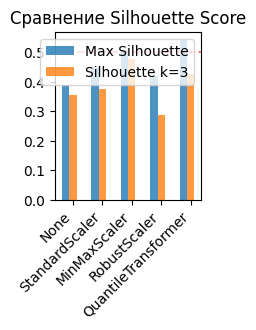

In [17]:
# График 1: Сравнение метрик
ax1 = plt.subplot(2, 3, 1)
metrics_df = comparison_df.set_index('Normalization')
x = np.arange(len(metrics_df))
width = 0.25

ax1.bar(x - width, metrics_df['Max_Silhouette'], width, label='Max Silhouette', alpha=0.8)
ax1.bar(x, metrics_df['Silhouette_k=3'], width, label='Silhouette k=3', alpha=0.8)
ax1.set_title('Сравнение Silhouette Score')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_df.index, rotation=45, ha='right')
ax1.legend()
ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)


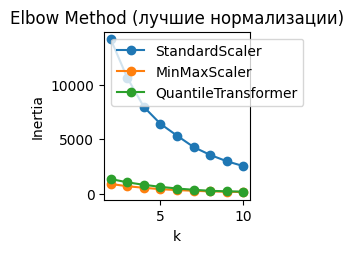

In [18]:
# График 2: Elbow curves для лучших
ax2 = plt.subplot(2, 3, 2)
for name in ['StandardScaler', 'MinMaxScaler', best_norm]:
    if name in results:
        ax2.plot(k_range, results[name]['inertias'], 'o-', label=name)
ax2.set_title('Elbow Method (лучшие нормализации)')
ax2.set_xlabel('k')
ax2.set_ylabel('Inertia')
ax2.legend()


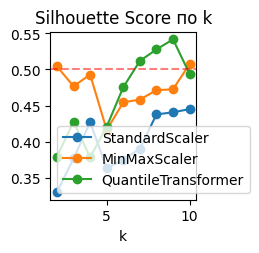

In [19]:
# График 3: Silhouette curves
ax3 = plt.subplot(2, 3, 3)
for name in ['StandardScaler', 'MinMaxScaler', best_norm]:
    if name in results:
        ax3.plot(k_range, results[name]['silhouettes'], 'o-', label=name)
ax3.set_title('Silhouette Score по k')
ax3.set_xlabel('k')
ax3.legend()
ax3.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)


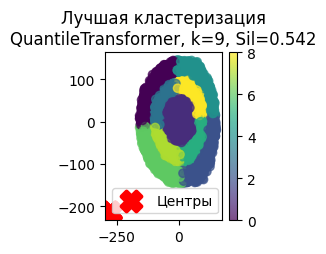

In [20]:
# График 4: Результат лучшей кластеризации (PCA)
ax4 = plt.subplot(2, 3, 4)
scatter4 = ax4.scatter(X_pca[:,0], X_pca[:,1], c=labels_best, cmap='viridis', alpha=0.7)
ax4.scatter(pca.transform(kmeans_best.cluster_centers_)[:,0], 
            pca.transform(kmeans_best.cluster_centers_)[:,1], 
           c='red', marker='X', s=200, linewidth=3, label='Центры')
ax4.set_title(f'Лучшая кластеризация\n{best_norm}, k={best_k}, Sil={final_sil:.3f}')
ax4.legend()
plt.colorbar(scatter4, ax=ax4)


Text(0.5, 0, 'Кластер')

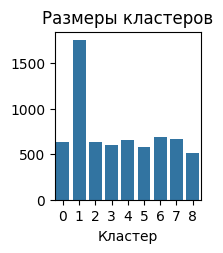

In [21]:
# График 5: Распределение кластеров
ax5 = plt.subplot(2, 3, 5)
cluster_sizes = pd.Series(labels_best).value_counts().sort_index()
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, ax=ax5)
ax5.set_title('Размеры кластеров')
ax5.set_xlabel('Кластер')


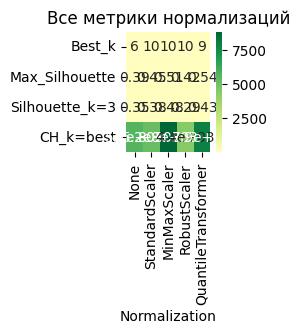

In [22]:
# График 6: Heatmap сравнения
ax6 = plt.subplot(2, 3, 6)
sns.heatmap(metrics_df.T, annot=True, cmap='RdYlGn', center=0.5, ax=ax6)
ax6.set_title('Все метрики нормализаций')

plt.tight_layout()
plt.savefig('clustering_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [23]:
# 10. Сохранение результатов
comparison_df.to_csv('normalization_comparison.csv', index=False)
centers_df = pd.DataFrame(kmeans_best.cluster_centers_, 
                         columns=[f'Feature_{i+1}' for i in range(X.shape[1])])
centers_df.index.name = 'cluster'
centers_df.to_csv('best_cluster_centers.csv')

print("\nТаблица сравнения:")
print(comparison_df.to_string(index=False))
print(f"\nЛучшая: {best_norm} (k={best_k}, Silhouette={final_sil:.4f})")



Таблица сравнения:
      Normalization  Best_k  Max_Silhouette  Silhouette_k=3  CH_k=best
               None       6          0.3873          0.3534  5716.7099
     StandardScaler      10          0.4451          0.3767  5189.9907
       MinMaxScaler      10          0.5075          0.4768  8830.1873
       RobustScaler      10          0.4187          0.2860  4393.7457
QuantileTransformer       9          0.5418          0.4275  7915.6320

Лучшая: QuantileTransformer (k=9, Silhouette=0.5418)



КЛАСТЕРИЗАЦИЯ С k=4 (как в исходных данных)
k=4 результаты (QuantileTransformer):
Silhouette: 0.3782
Calinski-Harabasz: 4191.71
ARI с истинными метками: 0.7642

ИТОГОВАЯ ТАБЛИЦА СРАВНЕНИЯ
               Метод  k  Silhouette  Calinski-Harabasz  ARI_истинные
0    Авто (лучший k)  9      0.5418          7867.9795        0.3819
1  Фиксированный k=4  4      0.3782          4191.7139        0.7642


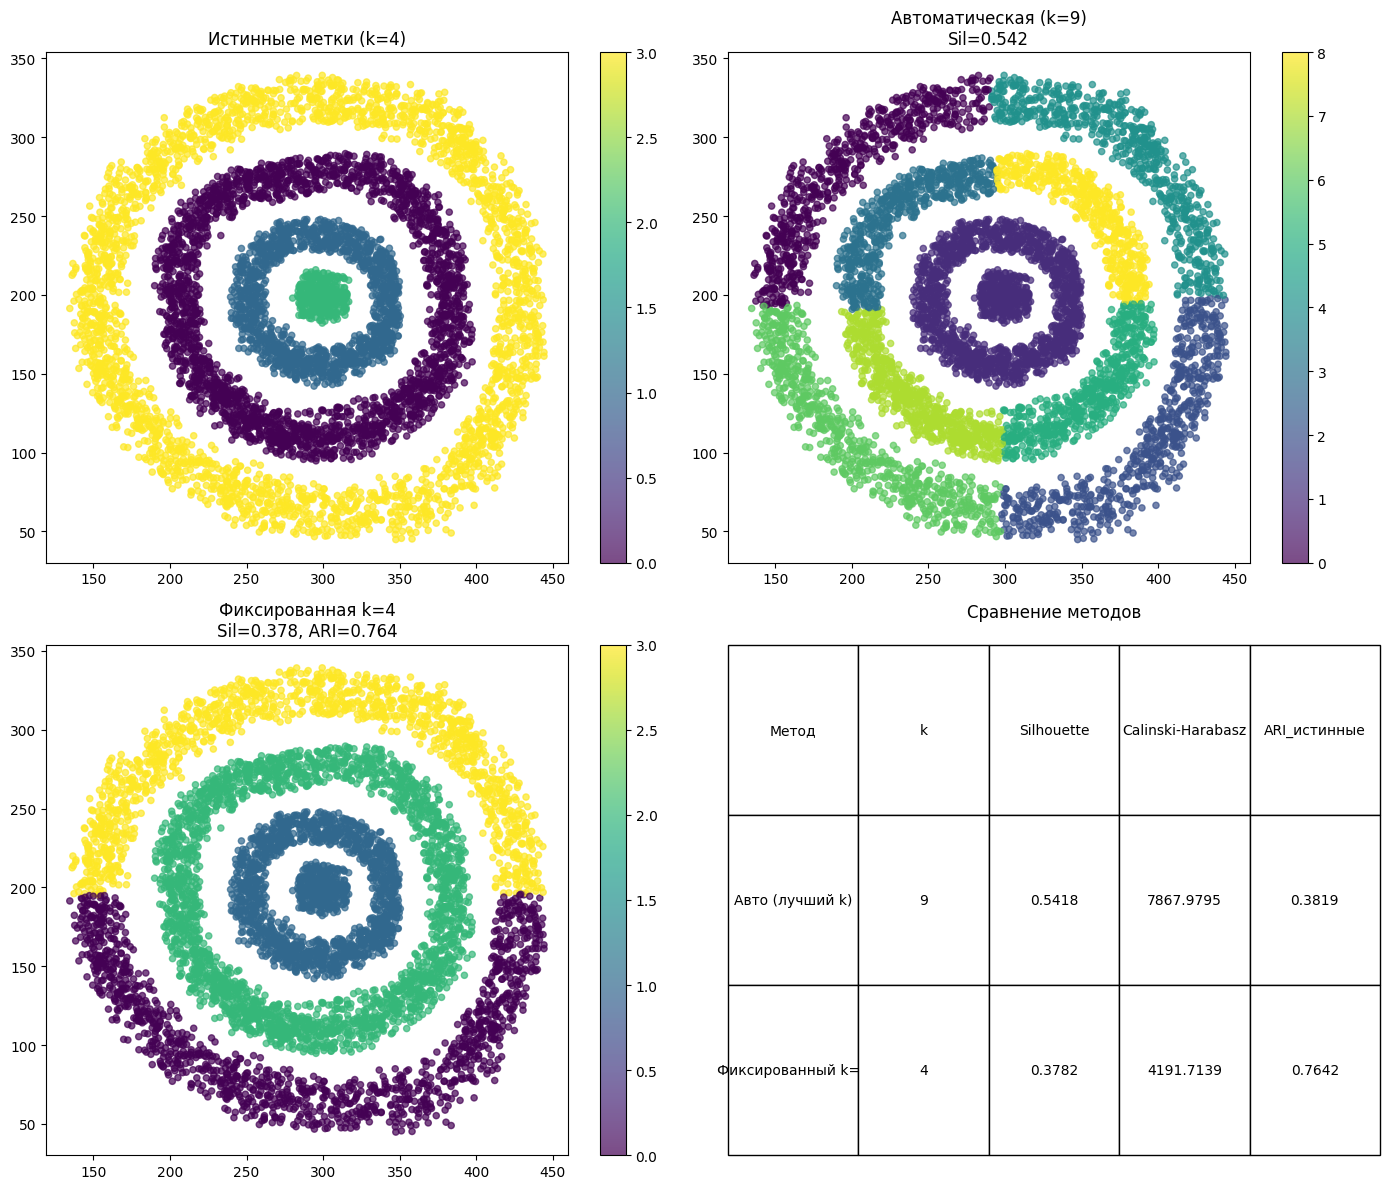


Сохранено: k4_vs_auto_comparison.png
Вывод: Автоматический k=9 ЛУЧШЕ по Silhouette


In [ ]:
# СРАВНЕНИЕ С ИСХОДНЫМ КОЛИЧЕСТВОМ КЛАСТЕРОВ (k=4)
from sklearn.metrics import adjusted_rand_score

print("\n" + "="*70)
print("КЛАСТЕРИЗАЦИЯ С k=4 (как в исходных данных)")
print("="*70)

# KMeans с фиксированным k=4 на лучшей нормализации
kmeans_k4 = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_k4 = kmeans_k4.fit_predict(X_best)

# Метрики для k=4
sil_k4 = silhouette_score(X_best, labels_k4)
ch_k4 = calinski_harabasz_score(X_best, labels_k4)

print(f"k=4 результаты (QuantileTransformer):")
print(f"Silhouette: {sil_k4:.4f}")
print(f"Calinski-Harabasz: {ch_k4:.2f}")

# Сравнение с истинными метками
true_labels = data['color']
ari_k4 = adjusted_rand_score(true_labels, labels_k4)
print(f"ARI с истинными метками: {ari_k4:.4f}")

# ПОЛНАЯ ТАБЛИЦА СРАВНЕНИЯ
print("\n" + "="*50)
print("ИТОГОВАЯ ТАБЛИЦА СРАВНЕНИЯ")
print("="*50)

comparison_final = pd.DataFrame({
    'Метод': ['Авто (лучший k)', 'Фиксированный k=4'],
    'k': [best_k, 4],
    'Silhouette': [final_sil, sil_k4],
    'Calinski-Harabasz': [final_ch, ch_k4],
    'ARI_истинные': [adjusted_rand_score(true_labels, labels_best), ari_k4]
}).round(4)

print(comparison_final)

# ВИЗУАЛИЗАЦИЯ: 4 кластера vs Автоматические 9
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Истинные метки
scatter1 = axes[0,0].scatter(data['x'], data['y'], c=true_labels, cmap='viridis', alpha=0.7, s=20)
axes[0,0].set_title('Истинные метки (k=4)')
plt.colorbar(scatter1, ax=axes[0,0])

# 2. Автоматическая кластеризация (k=9)
scatter2 = axes[0,1].scatter(data['x'], data['y'], c=labels_best, cmap='viridis', alpha=0.7, s=20)
axes[0,1].set_title(f'Автоматическая (k={best_k})\nSil={final_sil:.3f}')
plt.colorbar(scatter2, ax=axes[0,1])

# 3. Фиксированная k=4
scatter3 = axes[1,0].scatter(data['x'], data['y'], c=labels_k4, cmap='viridis', alpha=0.7, s=20)
axes[1,0].set_title(f'Фиксированная k=4\nSil={sil_k4:.3f}, ARI={ari_k4:.3f}')
plt.colorbar(scatter3, ax=axes[1,0])

# 4. Таблица сравнения
axes[1,1].axis('tight')
axes[1,1].axis('off')
table = axes[1,1].table(cellText=comparison_final.values, 
                       colLabels=comparison_final.columns, 
                       cellLoc='center', loc='center', bbox=[0,0,1,1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
axes[1,1].set_title('Сравнение методов', pad=20)

plt.tight_layout()
plt.savefig('k4_vs_auto_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nСохранено: k4_vs_auto_comparison.png")
print(f"Вывод: {'k=4 ЛУЧШЕ' if sil_k4 > final_sil else f'Автоматический k={best_k} ЛУЧШЕ'} по Silhouette")


### при автоматическом определиении количества кластеров 2 центральных обьеденило в один и остальные разбил по 4. Решил проверить что будет, если указать вручную количество. Центральные два остались собраны в один, зато 3. кластер уже зорошо определяет а 4. разделил пополам.

Хоть и алгоритм определяет по силуэту, что автоматическое определение лучше, но визуально по графикам можно легко понять, что компютер опять врёт!